In [1]:
# !pip install matplotlib


In [2]:
from osgeo import gdal
import numpy as np
import math
import matplotlib.pyplot as plt
import os
import re

In [3]:
def pad_number(match):
    number = int(match.group(1))
    return format(number, "02d")

fixed_text = re.sub(r"^(\d+)", pad_number, "1")
fixed_text

'01'

### Get rectangle side length function

In [4]:
def get_scale_in_degrees_and_rect_side_in_px(seconds_cnt):
    # constants
    min_scale = 3
    default_pixel_num = 1200
    overlap_pixel_num = 1
    
    scale_in_degrees = seconds_cnt / min_scale
    rect_side = default_pixel_num * scale_in_degrees
    
    return (scale_in_degrees, rect_side)

In [5]:
get_scale_in_degrees_and_rect_side_in_px(6)

(2.0, 2400.0)

### Function takes big 2D array and returns smaller 2D array in according to passed sizes

In [6]:
# The function takes big 2D array and returns smaller 2D array in according to passed sizes
# If the function can't satisfy passed sizes of array, it returns array with less sizes
def get_2D_array_from_bigger_2D_array(init_arr, left_border, top_border,
                                        tile_size, overlap):
    
    bottom_border = len(init_arr)
    if(bottom_border - top_border > tile_size + overlap):
        bottom_border =  top_border + tile_size + overlap
    right_border = len(init_arr)
    if(right_border - left_border > tile_size + overlap):
        right_border = left_border + tile_size + overlap
        
    res_arr = []
    for i in range(bottom_border - top_border):
        res_arr += [init_arr[i + top_border, left_border : right_border]]
            
    return res_arr
        

### Function returns 2D array combined by equal axis from two 2D arrays

In [7]:
def combine_two_2d_arrays_by_equal_axis(first_arr, second_arr):
    if(first_arr.shape[0] == second_arr.shape[0]):
        return np.hstack((first_arr, second_arr))
    if(first_arr.shape[1] == second_arr.shape[1]):
        return np.vstack((first_arr, second_arr))

In [8]:
def get_2d_index_by_element_number(ncols, number):
    element_row = 0
    element_col = 0
    
    while number > ncols:
        number -= ncols
        element_row += 1
    
    element_col = number - 1
    
    return (element_row, element_col)

In [9]:
math.ceil(0.1)

1

### The function takes four elevation arrays (rectangles) and split top left one in tiles with defined size

In [10]:
def split_rect_in_defined_tiles(rects, tile_size, left_border, top_border, overlap):
    # Combine all rects to one entire rect
    two_top_combined_rects = np.hstack((rects[0], rects[1]))
    two_bottom_combined_rects = np.hstack((rects[2], rects[3]))
    entire_combined_rect = np.vstack((two_top_combined_rects, two_bottom_combined_rects))
    
    # Getting size of default rect (6000 px)
    rect_side_size = rects[0].shape[0]
    
    free_h_space = rect_side_size - left_border
    free_v_space = rect_side_size - top_border

    tiles_cnt_in_h_axis = math.ceil(free_h_space / tile_size)
    tiles_cnt_in_v_axis = math.ceil(free_v_space / tile_size)
#     print("**", tiles_cnt_in_h_axis, tiles_cnt_in_v_axis)
    
    right_shift = tiles_cnt_in_h_axis * tile_size - free_h_space
    bottom_shift = tiles_cnt_in_v_axis * tile_size - free_v_space
    
    res_tiles = []
            
    for i in range(tiles_cnt_in_v_axis):
        for j in range(tiles_cnt_in_h_axis):
            res_tiles += [get_2D_array_from_bigger_2D_array(entire_combined_rect, left_border + tile_size * j, 
                                                             top_border + tile_size * i, tile_size, overlap)]
#             print(left_border + tail_size * j, top_border + tail_size * i)
        
#     print("f", np.shape(res_tiles))
    return (res_tiles, right_shift, bottom_shift, tiles_cnt_in_v_axis, tiles_cnt_in_h_axis)

### The function calculates georeferencing data for tiles

In [11]:
def get_georeferencing_data(scale_in_deg, img_array, long_top_left, lat_top_left, long_delta, lat_delta, ncols, count):
    
    # get width and height of image array
    n_img_rows, n_img_cols = img_array.shape

    # The shift is one tile side length in degrees. It's should be float value
    shift = scale_in_deg

    img_row, img_col = get_2d_index_by_element_number(ncols, count)
    
    long_min_shifted = round(long_top_left + shift * img_col)
    lat_max_shifted = round(lat_top_left - shift * img_row)
    long_max_shifted = round(long_min_shifted + (long_delta * n_img_cols))
    lat_min_shifted = round(lat_max_shifted - (abs(lat_delta) * n_img_rows))
    
    return (long_min_shifted, lat_max_shifted, long_max_shifted, lat_min_shifted)

### The function rounds an one dim array 

In [12]:
def round_one_dim_array_to_default_scale(init_arr, init_arr_scale_in_deg):
    rounded_arr = []
    init_arr_length = len(init_arr)
    
    for i in range(0, init_arr_length - 1, int(init_arr_scale_in_deg)):
        average = 0
        for j in range(i, i + int(init_arr_scale_in_deg)):
            average += init_arr[j]
        average /= int(init_arr_scale_in_deg)
        rounded_arr.append(average)
    
    return rounded_arr

### The function rounds an 2D array values in order to set the array scale to min tile scale

In [13]:
def round_2D_array_to_default_scale(init_arr, init_arr_scale_in_deg):
    rounded_arr = []
    init_arr_side = np.shape(init_arr)[0]
    
    # rows (vertical direction)
    for i in range(0, init_arr_side - 1, int(init_arr_scale_in_deg)): 
        temp_arr = []
        #cols (horizontal direction)
        for j in range(0, init_arr_side - 1, int(init_arr_scale_in_deg)): 
            average = 0 
            for inner_i in range(i, i + int(init_arr_scale_in_deg)): 
                for inner_j in range(j, j + int(init_arr_scale_in_deg)):
                    average += init_arr[inner_i][inner_j]
            average /= int(init_arr_scale_in_deg) ** 2
            temp_arr.append(average)
        temp_arr.append(init_arr[i][init_arr_side - 1])
#         print(temp_arr[10:100])
        rounded_arr += [temp_arr]
    last_rounded_row = round_one_dim_array_to_default_scale(init_arr[init_arr_side - 1], init_arr_scale_in_deg)
    last_rounded_row.append(init_arr[init_arr_side - 1][init_arr_side - 1])
#     print("***", np.shape(last_rounded_row))
    rounded_arr += [last_rounded_row]
#     print("****", np.shape(rounded_arr))
    
    return np.asarray(rounded_arr)

In [14]:
list1 = [1,2,3,4,5]
list2 = [6,7,8,9,0]

list3 = []
list3 += [list1]
list3 += [list2]

np.shape(list3)


(2, 5)

### The function displays data with grid of plots

In [15]:
def plot_image_grid(images, gdal_current_ds, right_shift, bottom_shift, scale_in_deg, res_dict, 
                                                                ncols, nrows, cmap='gist_earth'):    
    '''Plot a grid of images'''
#     if not ncols:
#     factors = [i for i in range(1, len(images)+1) if len(images) % i == 0]
#     ncols = factors[len(factors) // 2] if len(factors) else len(images) // 4 + 1
#     nrows = int(len(images) / ncols) + int(len(images) % ncols)
    print("^", ncols, nrows)
#     ncols = int(math.sqrt(np.shape(images)[0]))
#     nrows = int(math.sqrt(np.shape(images)[1]))
    imgs = [images[i] if len(images) > i else None for i in range(nrows * ncols)]
    f, axes = plt.subplots(nrows, ncols, figsize=(4*ncols, 4*nrows))
    axes = axes.flatten()[:len(imgs)]
    
#     print("rows, cols:", nrows, ncols)
    
    count = 1
    default_scale_in_deg = 5
    default_scale_in_px = 1200
    long_min, long_delta, dxdy, lat_max, dydx, lat_delta = gdal_current_ds.GetGeoTransform()

    long_top_left = long_min + (right_shift / default_scale_in_px) # !!! не всегда
    lat_top_left = lat_max #- (bottom_shift / default_scale_in_px)

    for img, ax in zip(imgs, axes.flatten()): 
        if np.any(img):
            if len(img.shape) > 2 and img.shape[2] == 1:
                img = img.squeeze()
                
            ax.title.set_text(count)
            long_min_shifted, lat_max_shifted, long_max_shifted, lat_min_shifted = get_georeferencing_data(
                                                scale_in_deg, img, long_top_left, lat_top_left, 
                                                long_delta, lat_delta, ncols, count)
            
            # Here I need to round img if it has scale more than min scale (1 deg)
            if(int(scale_in_deg) > 1):
                img = round_2D_array_to_default_scale(img, scale_in_deg)
                
#             print("*", img.shape)
            ax.imshow(img, cmap=cmap, extent=[long_min_shifted, long_max_shifted, lat_min_shifted, lat_max_shifted])
            count += 1

            res_dict[(lat_max_shifted, lat_min_shifted, long_min_shifted, long_max_shifted)] = img
            

## Start of execution

In [20]:
cap_array = np.full((6000, 6000), -32768)
a = cap_array
b = cap_array

b[0][0] = 1

print(a)
print(b)

[[     1 -32768 -32768 ... -32768 -32768 -32768]
 [-32768 -32768 -32768 ... -32768 -32768 -32768]
 [-32768 -32768 -32768 ... -32768 -32768 -32768]
 ...
 [-32768 -32768 -32768 ... -32768 -32768 -32768]
 [-32768 -32768 -32768 ... -32768 -32768 -32768]
 [-32768 -32768 -32768 ... -32768 -32768 -32768]]
[[     1 -32768 -32768 ... -32768 -32768 -32768]
 [-32768 -32768 -32768 ... -32768 -32768 -32768]
 [-32768 -32768 -32768 ... -32768 -32768 -32768]
 ...
 [-32768 -32768 -32768 ... -32768 -32768 -32768]
 [-32768 -32768 -32768 ... -32768 -32768 -32768]
 [-32768 -32768 -32768 ... -32768 -32768 -32768]]


In [17]:
gdal.UseExceptions()

def pad_number(match):
    number = int(match.group(1))
    return format(number, "02d")

gdal_ds = []
srtm_tile_h_cnt = 72
srtm_tile_v_cnt = 24

ds_sub_list = []

tile_arrays_by_grid_coords = {}

v_num = re.sub(r"^(\d+)", pad_number, str(1))
h_num = re.sub(r"^(\d+)", pad_number, str(10))

grid_coords = h_num + '_' + v_num
path_to_dir = './' + grid_coords

path_to_file = path_to_dir + '/srtm_' + grid_coords + '.tif'

p = gdal.Open(path_to_file)
n = p.GetRasterBand(1)
k = n.ReadAsArray()

for v in range(1, srtm_tile_v_cnt + 1):
    for h in range(1, srtm_tile_h_cnt + 1):
        v_num = re.sub(r"^(\d+)", pad_number, str(v))
        h_num = re.sub(r"^(\d+)", pad_number, str(h))
        
        grid_coords = h_num + '_' + v_num
        path_to_dir = './' + grid_coords
        
        path_to_file = path_to_dir + '/srtm_' + grid_coords + '.tif'
        
        if(os.path.isdir(path_to_dir)):
            if(os.path.isfile(path_to_file)):
                ds = gdal.Open(path_to_file)
                band = ds.GetRasterBand(1)
                elevations = band.ReadAsArray()
                tile_arrays_by_grid_coords[grid_coords] = elevations
                

rects = [[], [], [], []]        
cap_array = np.full((6000, 6000), -32768)

for v in range(1, srtm_tile_v_cnt + 1):
    for h in range(1, srtm_tile_h_cnt + 1):
        v_tile_coord = re.sub(r"^(\d+)", pad_number, str(v))
        h_tile_coord = re.sub(r"^(\d+)", pad_number, str(h))
        grid_coords = h_tile_coord + '_' + v_tile_coord
        
        if grid_coords in tile_arrays_by_grid_coords:
            rects[0] = tile_arrays_by_grid_coords[grid_coords]
            # надо проверять граничные случаи. Если есть тайл на противоположном 
            # конце -- брать его. Если нет -- добавлять пустышку
            other_v_tile_coord = re.sub(r"^(\d+)", pad_number, str(v))
            other_h_tile_coord = re.sub(r"^(\d+)", pad_number, str(h))
            if h_num + '_' + v_num
        
                
    
# print(tile_arrays_by_grid_coords)

# ds1 = gdal.Open('./10_01/srtm_10_01.tif')
# ds2 = gdal.Open('./11_01/srtm_11_01.tif')
# ds3 = gdal.Open('./12_01/srtm_12_01.tif')
# ds4 = gdal.Open('./10_02/srtm_10_02.tif')
# ds5 = gdal.Open('./11_02/srtm_11_02.tif')
# ds6 = gdal.Open('./12_02/srtm_12_02.tif')

# gdal_ds = [[ds1, ds2], [ds4, ds5]]

# elevations_list = [[], []]

# for i in range(len(gdal_ds[0])):
#     band1 = gdal_ds[0][i].GetRasterBand(1)
#     band2 = gdal_ds[1][i].GetRasterBand(1)
#     elevations_list[0] += [band1.ReadAsArray()]
#     elevations_list[1] += [band2.ReadAsArray()]

# elev_arr = np.asarray(elevations_list)

01_01
02_01
03_01
04_01
05_01
06_01
07_01
08_01
09_01
10_01
11_01
12_01
13_01
14_01
15_01
16_01
17_01
18_01
19_01
20_01
21_01
22_01
23_01
24_01
25_01
26_01
27_01
28_01
29_01
30_01
31_01
32_01
33_01
34_01
35_01
36_01
37_01
38_01
39_01
40_01
41_01
42_01
43_01
44_01
45_01
46_01
47_01
48_01
49_01
50_01
51_01
52_01
53_01
54_01
55_01
56_01
57_01
58_01
59_01
60_01
61_01
62_01
63_01
64_01
65_01
66_01
67_01
68_01
69_01
70_01
71_01
72_01
01_02
02_02
03_02
04_02
05_02
06_02
07_02
08_02
09_02
10_02
11_02
12_02
13_02
14_02
15_02
16_02
17_02
18_02
19_02
20_02
21_02
22_02
23_02
24_02
25_02
26_02
27_02
28_02
29_02
30_02
31_02
32_02
33_02
34_02
35_02
36_02
37_02
38_02
39_02
40_02
41_02
42_02
43_02
44_02
45_02
46_02
47_02
48_02
49_02
50_02
51_02
52_02
53_02
54_02
55_02
56_02
57_02
58_02
59_02
60_02
61_02
62_02
63_02
64_02
65_02
66_02
67_02
68_02
69_02
70_02
71_02
72_02
01_03
02_03
03_03
04_03
05_03
06_03
07_03
08_03
09_03
10_03
11_03
12_03
13_03
14_03
15_03
16_03
17_03
18_03
19_03
20_03
21_03
22_03
23_0

^ 2 2
(60, 56, -135, -131) (1201, 1201)
(60, 56, -131, -127) (1201, 1201)
(56, 52, -135, -131) (1201, 1201)
(56, 52, -131, -127) (1201, 1201)


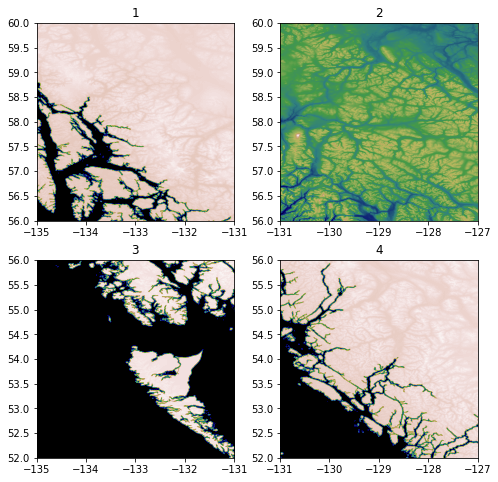

In [132]:
seconds_cnt = 12
scale_in_deg, rect_side_in_px = get_scale_in_degrees_and_rect_side_in_px(seconds_cnt)

res_dict = {}
rects = [[], [], [], []]

prev_right_shift = 0
prev_bottom_shift = 0

for i in range(len(elev_arr[0]) - 1):
    rects[0] = elev_arr[0][i]
    rects[1] = elev_arr[0][i + 1]
    rects[2] = elev_arr[1][i]
    rects[3] = elev_arr[1][i + 1]
    
    tiles, right_shift, bottom_shift, nrows, ncols = split_rect_in_defined_tiles(rects, int(rect_side_in_px), 
                                                                   prev_right_shift, 0, 1)
#     print("&", len(tiles))

#     temp(np.array(tiles), gdal_ds[0][i], prev_right_shift, prev_bottom_shift, scale_in_deg, res_dict)
    plot_image_grid(np.array(tiles), gdal_ds[0][i], prev_right_shift, 0, scale_in_deg, res_dict, ncols, nrows)
    prev_right_shift = right_shift
    prev_bottom_shift = bottom_shift
    
#     print("*", prev_right_shift, prev_bottom_shift)

for key, value in res_dict.items():
    print(key, np.shape(value))
    


### Writing to a .bin file

In [133]:
# f = open('./res/myfile2.bin', 'wb')
is_first = False
rect_side1 = 0


for coords, img in res_dict.items():
    filename = str(abs(coords[0]))
    filename += "N" if coords[0] >= 0 else "S"
    filename += str(abs(coords[2]))
    filename += "E" if coords[2] >= 0 else "W"

    with open('./res/' + filename + '.bin', 'wb') as f:
        # 2.3. The loop of matrix traversal
        for row in res_dict[coords]:
            if not is_first:
                rect_side1 = len(row)
                print(len(row))
                is_first = True
            # here you just need to write lines with the character '\n'
            for item in row:
                item = str(item) + '\n'
                bt = item.encode() # str=>bytes
                f.write(bt) # write bt to file

# 2.3. Close file
f.close();

1201


### Reading a .bin file

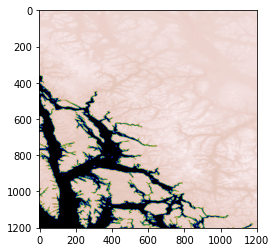

In [134]:
# 3.1. Open file for reading
f = open('./res/60N135W.bin', 'rb')

# 3.2. A new matrix
out_img = []

# 3.3.2. Loop of reading the lines and the creation of a matrix size m2*n2
i = 0
while i < rect_side1: # m2 rows in matrix
    row = [] # one row in list
    j = 0
    while j < rect_side1:
        bs = f.readline() # read one element of type bytes
        s = bs.decode() # convert bytes=>str
        s = s[:-1] # remove '\n'
        num = float(s)
        row += [num] # add to the list
        j = j + 1
    out_img += [row] # add one row of the list to the matrix
    i = i + 1

# i = 0
# while i < 100:
#     print("out_img[", i, "] = ", out_img[i])
#     i = i + 1
    
plt.imshow(out_img, cmap='gist_earth')
plt.show()

In [ ]:
wtf???